In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)  # suppress warnings
import random

In [3]:
SEED = 123

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [4]:
IMAGE_SIZE = 299
BATCH_SIZE = 16
EPOCHS = 20
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Loading the Dataset

In [5]:
dataset  = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/ML Implementation/Corn-disease/corn_disease_dataset/data",
     shuffle = True,
     seed=SEED,
     image_size = (IMAGE_SIZE, IMAGE_SIZE),
     batch_size = BATCH_SIZE
)

Found 4814 files belonging to 4 classes.


In [6]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [7]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

(16, 299, 299, 3)
[3 2 0 2 1 1 3 3 3 2 3 3 0 1 2 0]


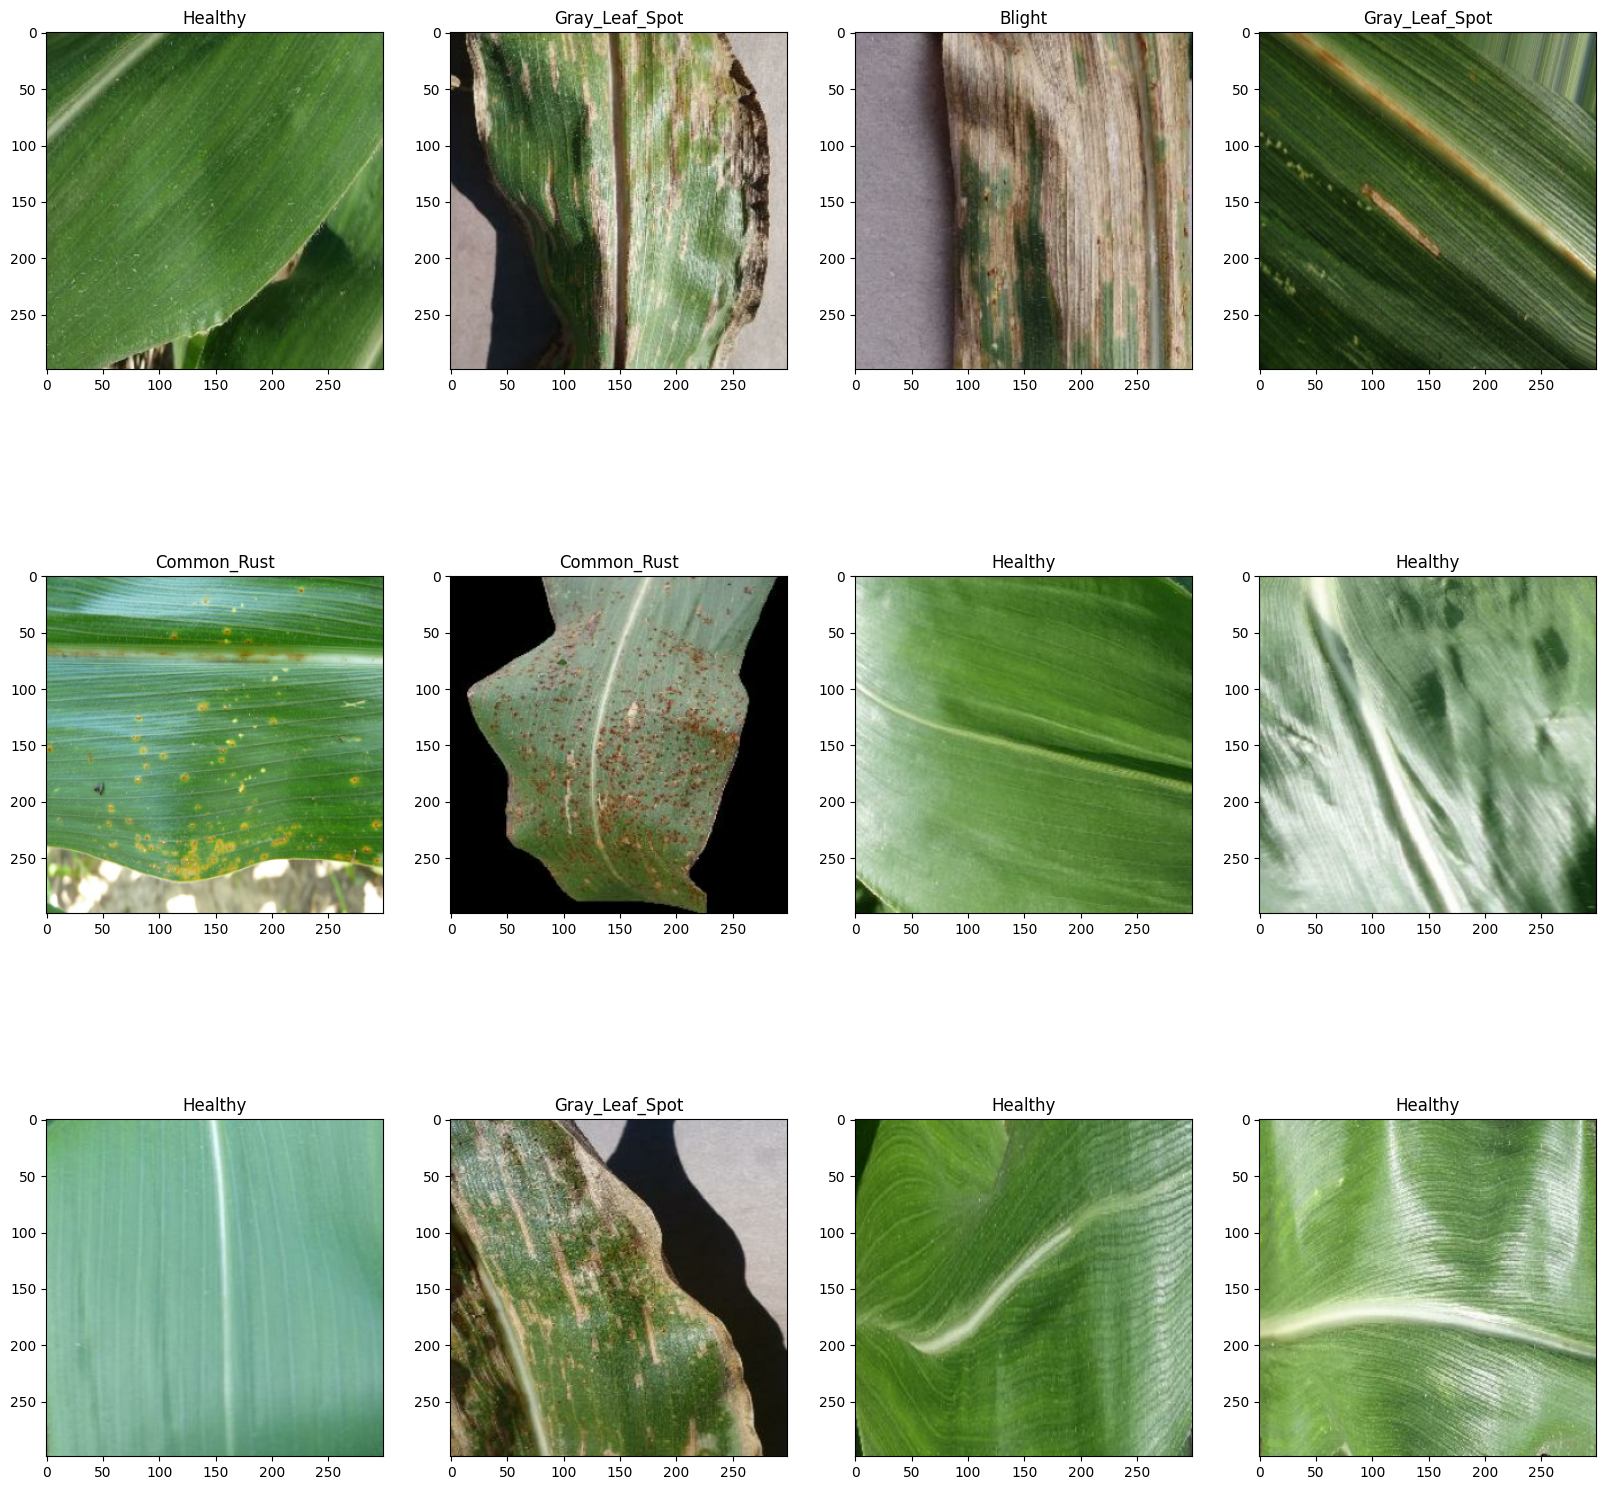

In [8]:
plt.figure(figsize = (20,20)) # Lets increse plot size of our plots
#Lets explore our batch and display some images
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
    #To visualize all images plot as subplot 
        ax = plt.subplot(3,4,i+1)
    #Visualize image using matplotlib imshow function plt.imshow expects a 3D numpy array
        plt.title(class_names[label_batch[i]]) # Displaying its class label as title
        plt.imshow(image_batch[i].numpy().astype('uint8'))
    print(image_batch.shape)
    print(label_batch.numpy())

In [9]:
y = np.concatenate([y for x, y in dataset], axis=0)
print(np.bincount(y))#np.bincount(array) counts occurence of each element in array.

[1146 1306 1200 1162]


# Data Partition

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    # Count dataset size
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=SEED)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
len(train_ds)

240

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Rescaling & Augmentation

In [14]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255)
])

In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [16]:
# Apply resize & rescale to all datasets
train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))

In [17]:
# Apply augmentation only to training
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=AUTOTUNE)

# Loading the Model : InceptionV3

In [18]:
from keras.applications import InceptionV3
inceptionv3 = InceptionV3(input_shape=INPUT_SHAPE, weights='imagenet', include_top=False)

In [19]:
for layer in inceptionv3.layers:
    layer.trainable = False

In [21]:
x = tf.keras.layers.GlobalAveragePooling2D()(inceptionv3.output)
x = layers.Dropout(0.2)(x)
prediction = tf.keras.layers.Dense(4, activation='softmax')(x)

# create a model object
model = tf.keras.models.Model(inputs=inceptionv3.input, outputs=prediction)

base_learning_rate = 1e-4
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer= tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    metrics=['accuracy']
)

In [22]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0]

# Fitting the Model

In [23]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/20
240/240 [==============================] - 226s 896ms/step - loss: 0.8744 - accuracy: 0.6712 - val_loss: 0.6551 - val_accuracy: 0.8062
Epoch 2/20
240/240 [==============================] - 204s 850ms/step - loss: 0.5323 - accuracy: 0.8174 - val_loss: 0.5030 - val_accuracy: 0.8354
Epoch 3/20
240/240 [==============================] - 200s 833ms/step - loss: 0.4277 - accuracy: 0.8489 - val_loss: 0.4317 - val_accuracy: 0.8583
Epoch 4/20
240/240 [==============================] - 191s 797ms/step - loss: 0.3668 - accuracy: 0.8708 - val_loss: 0.3907 - val_accuracy: 0.8729
Epoch 5/20
240/240 [==============================] - 194s 808ms/step - loss: 0.3303 - accuracy: 0.8786 - val_loss: 0.3586 - val_accuracy: 0.8813
Epoch 6/20
240/240 [==============================] - 189s 789ms/step - loss: 0.3043 - accuracy: 0.8900 - val_loss: 0.3396 - val_accuracy: 0.8771
Epoch 7/20
240/240 [==============================] - 201s 839ms/step - loss: 0.2853 - accuracy: 0.8968 - val_loss: 0.3180 -

# Fine Tuning the Model

In [24]:
for layer in inceptionv3.layers:
    layer.trainable = True

In [25]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(inceptionv3.layers))

# Fine-tune from this layer onwards
fine_tune_at = 249

# Freeze all the layers before the `fine_tune_at` layer
for layer in inceptionv3.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  311


In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0]

In [28]:
len(model.trainable_variables)

38

In [29]:
fine_tune_epochs = 5
total_epochs =  EPOCHS + fine_tune_epochs

In [30]:
history_fine = model.fit(train_ds,epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data=val_ds,batch_size = 16,verbose =1)

Epoch 20/25
240/240 [==============================] - 269s 1s/step - loss: 0.2354 - accuracy: 0.9153 - val_loss: 0.1197 - val_accuracy: 0.9542
Epoch 21/25
240/240 [==============================] - 267s 1s/step - loss: 0.1271 - accuracy: 0.9505 - val_loss: 0.1051 - val_accuracy: 0.9542
Epoch 22/25
240/240 [==============================] - 267s 1s/step - loss: 0.0942 - accuracy: 0.9677 - val_loss: 0.1189 - val_accuracy: 0.9542
Epoch 23/25
240/240 [==============================] - 268s 1s/step - loss: 0.0732 - accuracy: 0.9745 - val_loss: 0.1109 - val_accuracy: 0.9708
Epoch 24/25
240/240 [==============================] - 266s 1s/step - loss: 0.0478 - accuracy: 0.9836 - val_loss: 0.1133 - val_accuracy: 0.9708
Epoch 25/25
240/240 [==============================] - 270s 1s/step - loss: 0.0427 - accuracy: 0.9851 - val_loss: 0.0598 - val_accuracy: 0.9812


In [31]:
acc = history.history['accuracy'] +history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] +  history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] +  history_fine.history['val_loss']

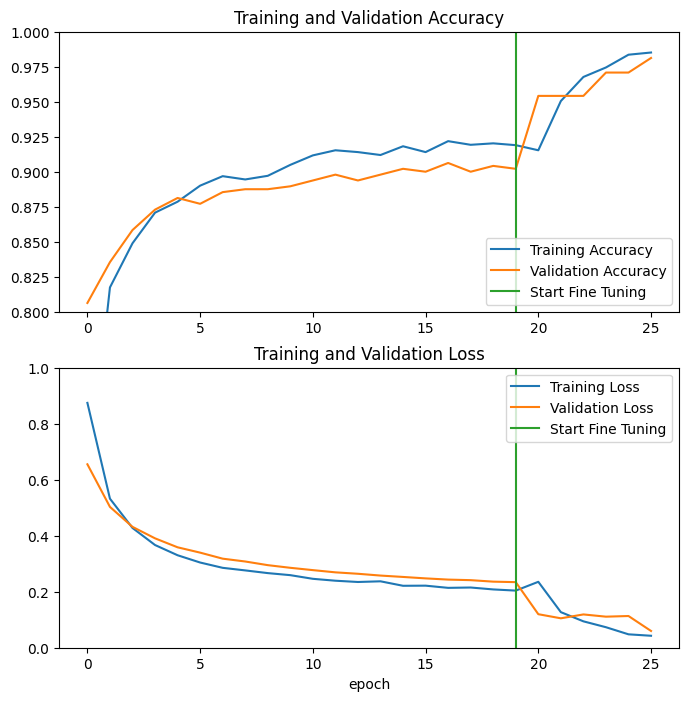

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

first image to print


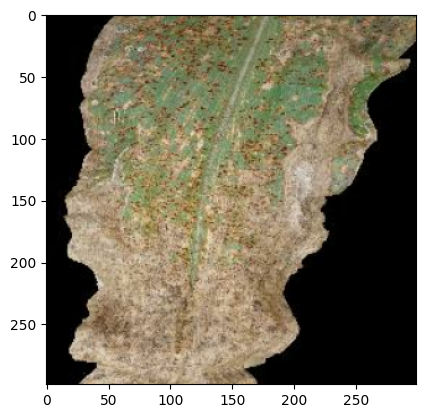

first image actual label: Common_Rust
1/1 [==============================] - 2s 2s/step
predicted label: Common_Rust


In [33]:
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy() * 255).astype('uint8')
    first_label = label_batch[0].numpy()

    print("first image to print")
    plt.imshow(first_image)
    plt.show()

    print("first image actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])


In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img, )
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 91ms/step


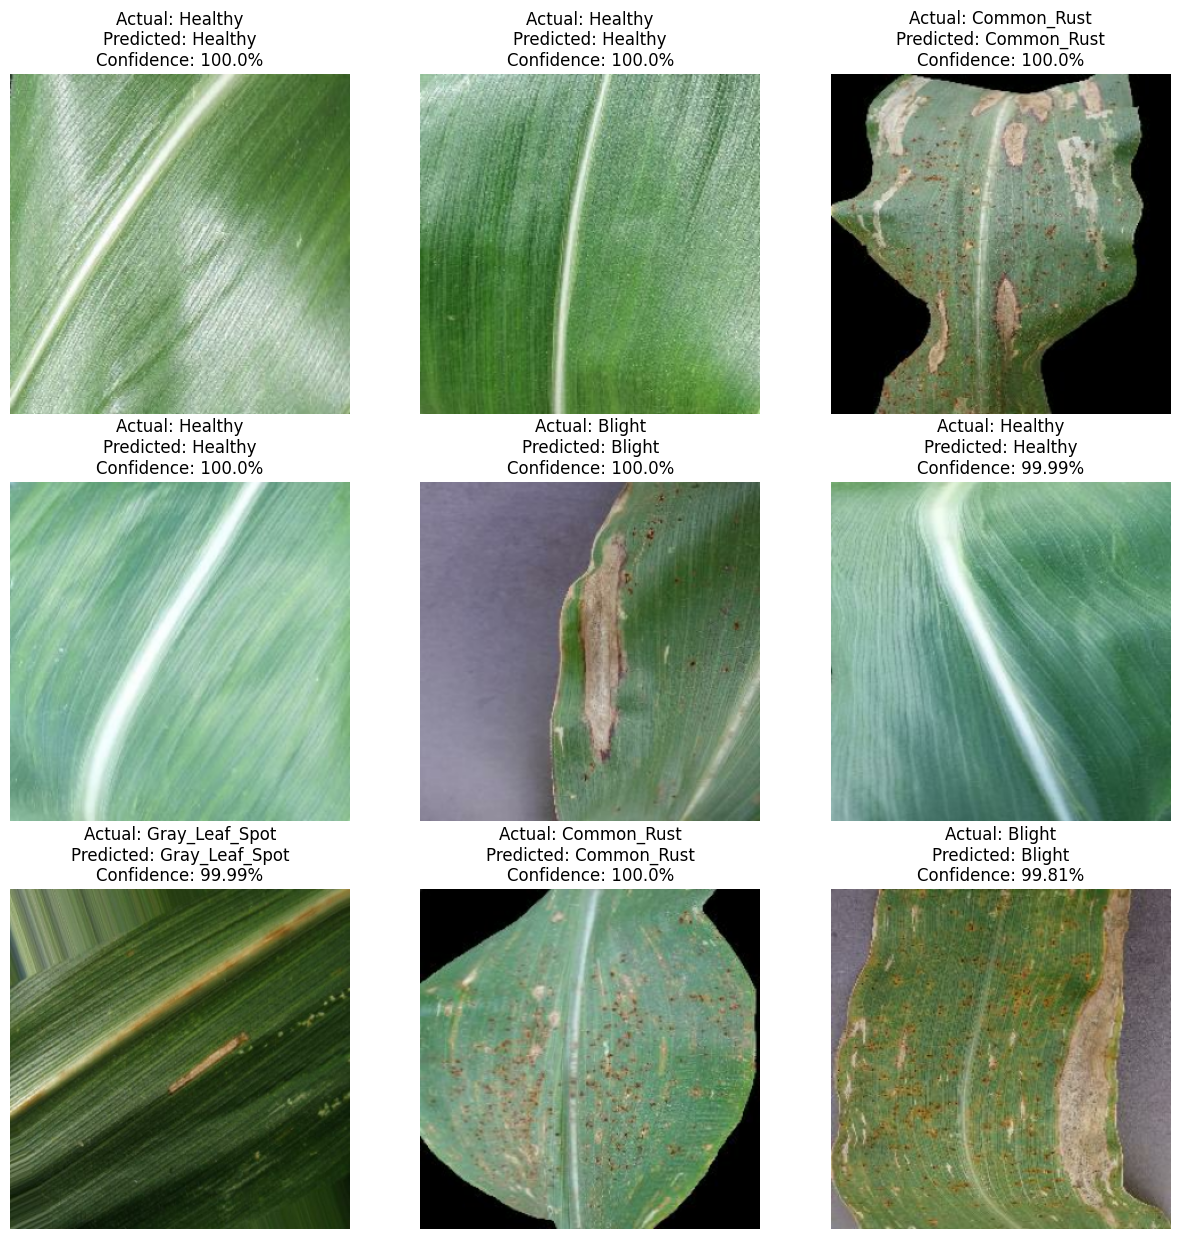

In [35]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        # rescale for display
        display_image = (images[i].numpy() * 255).astype("uint8")
        plt.imshow(display_image)
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")


# Model Predictions

In [36]:
import numpy as np

y_true = []
y_pred = []
y_prob = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=1)  # shape (batch_size,)
    true_classes = labels.numpy()             # shape (batch_size,)
    

    y_true.extend(true_classes)
    y_pred.extend(preds_classes)
    y_prob.extend(preds)
    
# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)  

1/1 [==============================] - 1s 568ms/step


In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Accuracy

In [39]:
acc = accuracy_score(y_true, y_pred)

In [40]:
print(f"Accuracy: {acc * 100:.2f}%")

Accuracy: 98.12%


# Precision

In [41]:
precision = precision_score(y_true, y_pred, average='weighted')  # or 'macro', 'micro'

In [42]:
print(f"Precision: {precision * 100:.2f}%")

Precision: 98.17%


# Recall


In [43]:
recall = recall_score(y_true, y_pred, average='weighted')

In [44]:
print(f"Recall: {recall * 100:.2f}%")

Recall: 98.12%


# F1-Score

In [45]:
f1 = f1_score(y_true, y_pred, average='weighted')

In [46]:
print(f"f1: {f1 * 100:.2f}%")

f1: 98.12%


# Confusion Matrix

In [47]:
cm = confusion_matrix(y_true, y_pred)

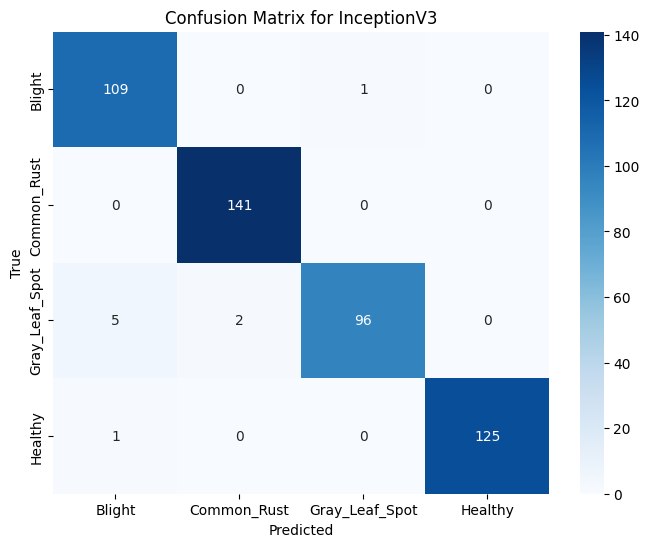

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for InceptionV3')
plt.show()


# AUROC

In [49]:
from sklearn.metrics import roc_auc_score

try:
    auc_score = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro') * 100
    print(f"Macro-Averaged ROC-AUC Score: {auc_score:.2f}%")
except Exception as e:
    print("ROC AUC not available:", e)


Macro-Averaged ROC-AUC Score: 99.89%


In [50]:
import os
print("Current working directory:", os.getcwd())

Current working directory: C:\ML Implementation\Corn-disease


In [51]:
model_version= "Inception_with_FT_299"
model.save(f"./models/{model_version}.keras")